In [1]:
# import library
# ========= choice of library ====
import tensorflow as tf
import matplotlib 
# configure backend here
matplotlib.use('Agg')
%matplotlib inline
import numpy as np
import sys, os,cv2
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from skimage.transform import resize
from scipy.misc import imread
from imgaug import augmenters as iaa
import nibabel as nib
import imgaug as ia
from scipy.ndimage import zoom
from sklearn.utils import shuffle
import matplotlib.animation as animation

plt.style.use('seaborn-white')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
np.random.seed(6278)
tf.set_random_seed(6728)
ia.seed(6278)

# Generate training data
import tensorflow as tf
old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)
from tensorflow.examples.tutorials.mnist import input_data
# ========= choice of library ====

In [2]:
# Get the certain STL 10 Data
from skimage import util 
data_location = "../../Dataset/STL10/img/4/"
train_data = []  # create an empty list
for dirName, subdirList, fileList in sorted(os.walk(data_location)):
    for filename in fileList:
        if ".png" in filename.lower() :
            train_data.append(os.path.join(dirName,filename))

image_resize_px = 64
train_batch = np.zeros(shape=(len(train_data),image_resize_px,image_resize_px))
for file_index in range(len(train_data)):
    train_batch[file_index] = resize(imread(train_data[file_index],mode='L'),(image_resize_px,image_resize_px))
            
# print out the data shape and the max and min value
train_batch = np.expand_dims(train_batch,3)
print('Train batch, min, max : ',train_batch.shape,train_batch.min(),train_batch.max())

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\ProgramData\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Train batch, min, max :  (500, 64, 64, 1) 0.0 1.0


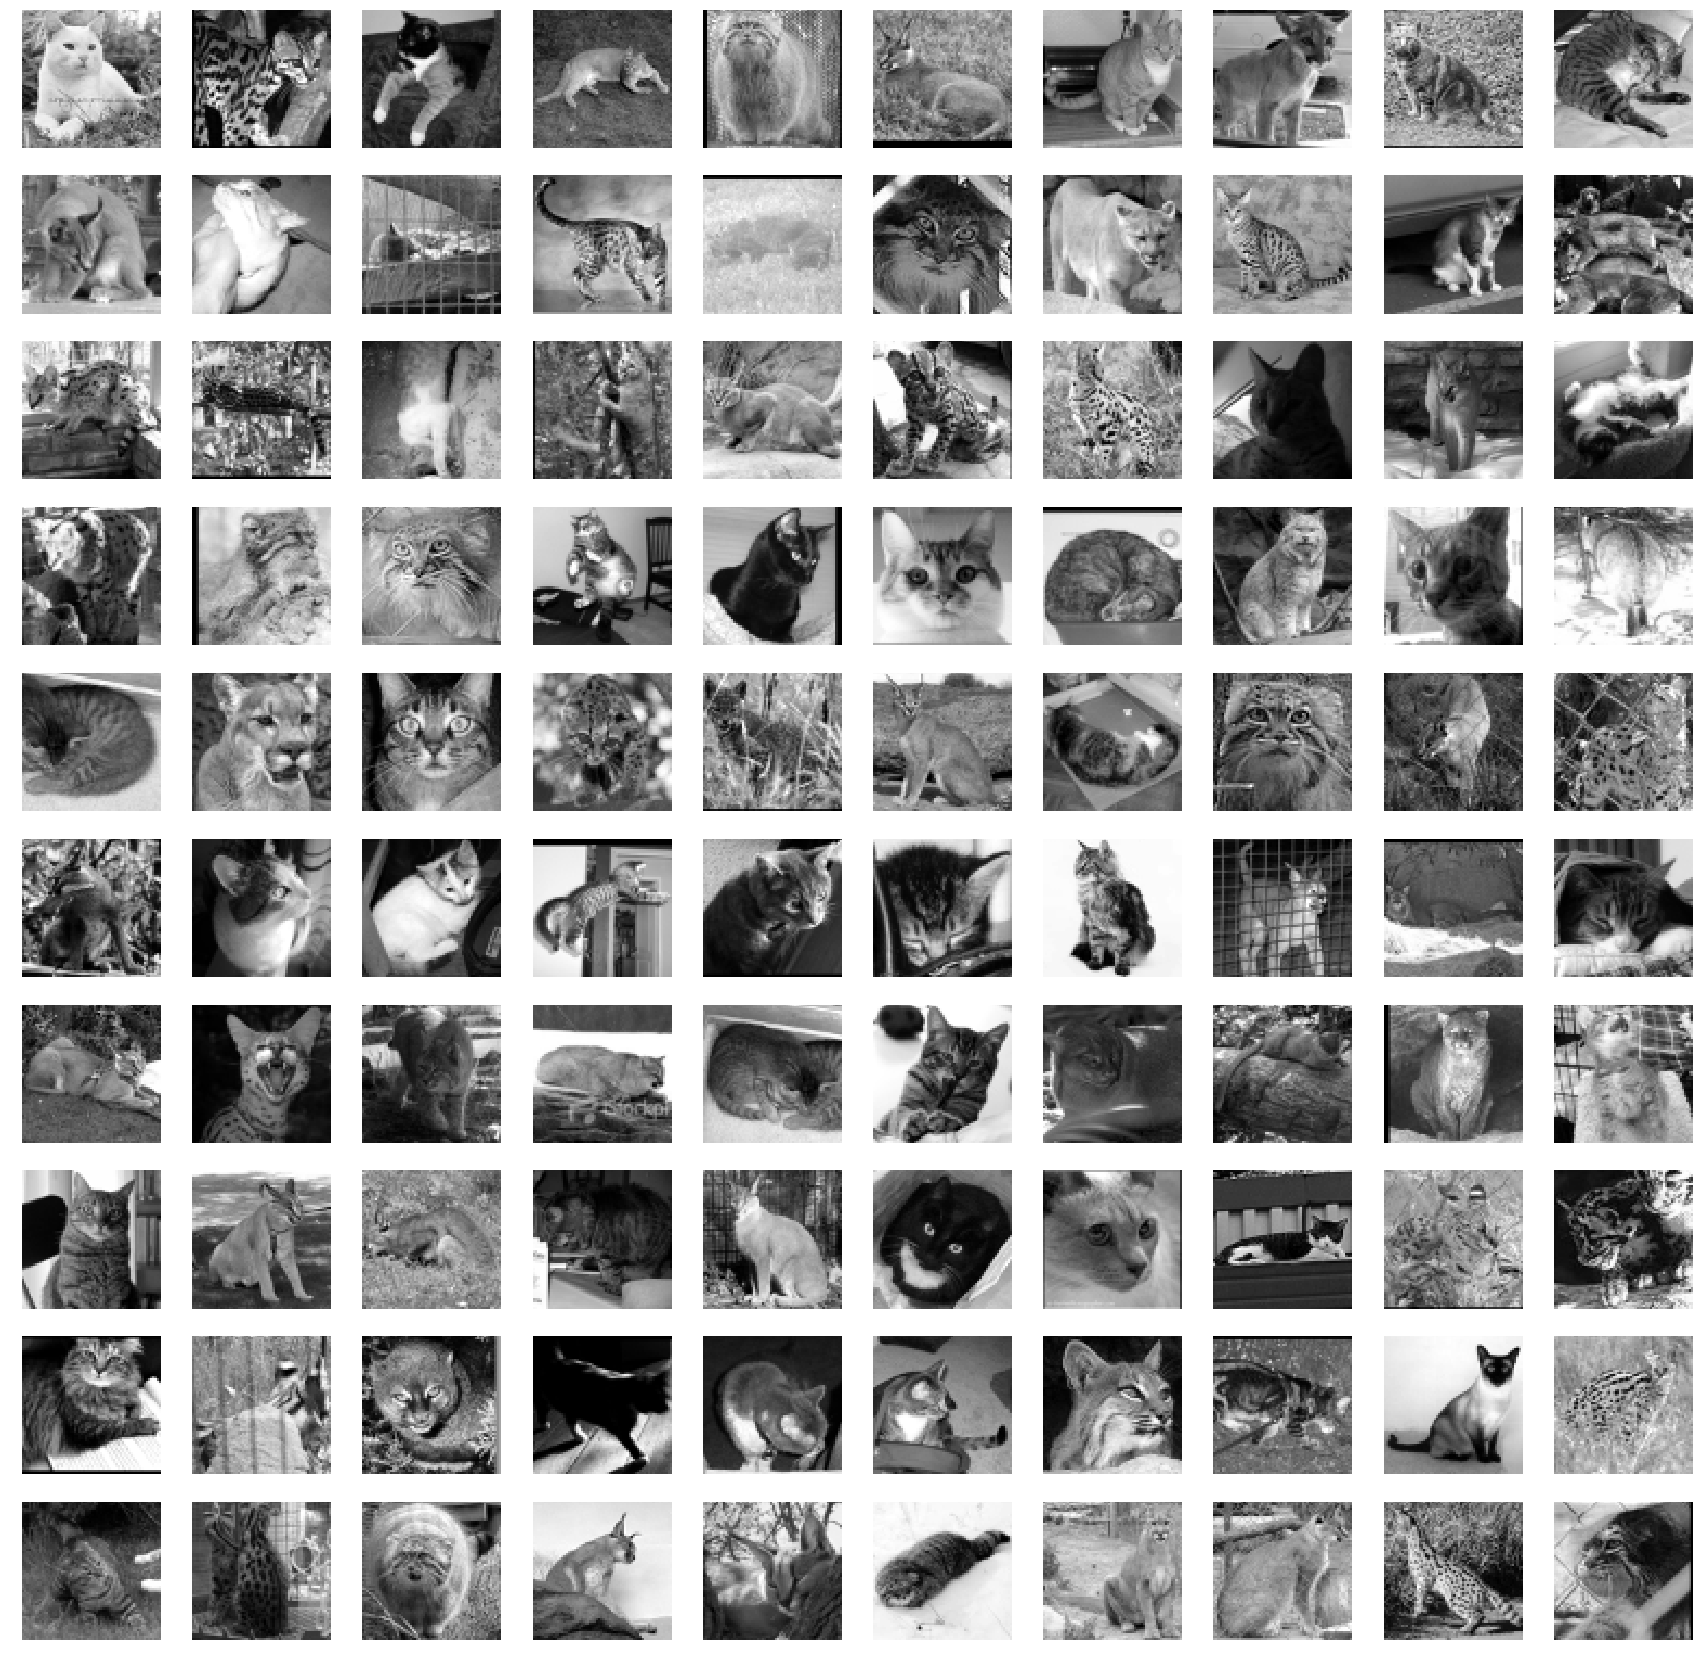

In [3]:
# view random 100 images
idx = np.random.permutation(len(train_batch))
train_batch = train_batch[idx]
fig=plt.figure(figsize=(30, 30))
columns = 10;rows = 10
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.squeeze(train_batch[i-1]),cmap='gray')
    plt.axis('off')
plt.show()